# 0. Packages


In [ ]:
import pandas as pd
import numpy as np
import random
import string
import re
import sys

# Read file module
from os import listdir
from os.path import isfile, join

# Tokenizer
!pip install pyvi
from pyvi import ViTokenizer, ViPosTagger
#from vncorenlp import VnCoreNLP

# Config
np.set_printoptions(threshold=sys.maxsize)
import warnings
warnings.filterwarnings('ignore')

# 1. Fetch data

In [ ]:
# Dataset is text file (.txt)
file_path = './dataset'
files = [f for f in listdir(file_path) if isfile(join(file_path, f))]
# print(files)

In [ ]:
categories = {}
for i, file in enumerate(files):
    file = file.replace('.txt', '')
    categories[i] = file
print('Tên các thể loại: ', categories)

Tên các thể loại:  {0: 'tdtu', 1: 'thông tin cá nhân', 2: 'bạn bè', 3: 'địa chỉ', 4: 'các câu hỏi phức tạp', 5: 'tán gẫu', 6: 'gia đình', 7: 'trò chuyện về đi ăn', 8: 'học tập', 9: 'sở thích', 10: 'đất nước', 11: 'nghỉ lễ', 12: 'robot', 13: 'giải trí', 14: 'nghề nghiệp', 15: 'du lịch', 16: 'shoping', 17: 'người yêu'}


In [ ]:
# from txt files to dict
dataset = {}
for idx, file in enumerate(files):
    if idx not in dataset:
        dataset[categories[idx]] = []
    lines = open(join(file_path, file), 'r', encoding='utf8')
    for line in lines:
        dataset[categories[idx]].append(line.strip())

In [ ]:
print('Tổng số thể loại hỏi đáp: ', len(dataset.keys()))
print('Tổng số câu từng thể loại')
for k, v in dataset.items():
    print('Thể loại \'{}\'. Số câu: {} câu'.format(k, len(v)))

Tổng số thể loại hỏi đáp:  18
Tổng số câu từng thể loại
Thể loại 'tdtu'. Số câu: 248 câu
Thể loại 'thông tin cá nhân'. Số câu: 775 câu
Thể loại 'bạn bè'. Số câu: 610 câu
Thể loại 'địa chỉ'. Số câu: 427 câu
Thể loại 'các câu hỏi phức tạp'. Số câu: 112 câu
Thể loại 'tán gẫu'. Số câu: 206 câu
Thể loại 'gia đình'. Số câu: 425 câu
Thể loại 'trò chuyện về đi ăn'. Số câu: 238 câu
Thể loại 'học tập'. Số câu: 263 câu
Thể loại 'sở thích'. Số câu: 245 câu
Thể loại 'đất nước'. Số câu: 201 câu
Thể loại 'nghỉ lễ'. Số câu: 181 câu
Thể loại 'robot'. Số câu: 170 câu
Thể loại 'giải trí'. Số câu: 271 câu
Thể loại 'nghề nghiệp'. Số câu: 407 câu
Thể loại 'du lịch'. Số câu: 230 câu
Thể loại 'shoping'. Số câu: 426 câu
Thể loại 'người yêu'. Số câu: 420 câu


In [ ]:
# Biểu đồ cột
bars = tuple(categories)
height = [len(v) for k, v in dataset.items()]
dataset_info = pd.DataFrame.from_dict({categories[i]: height[i] for i, category in enumerate(categories)}, orient='index', columns=['số câu'])

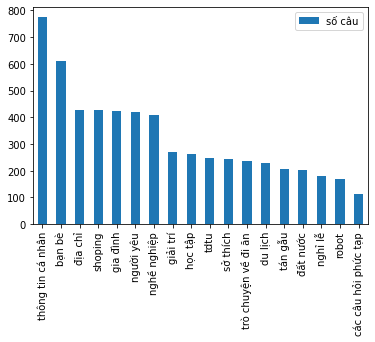

In [ ]:
dataset_info.sort_values(by='số câu', ascending=False).plot(kind='bar')

In [ ]:
# QA extraction
def QA_extraction(dataset, categories):
    errors = {'question': [], 'answer': []}
    data = {'question': [], 'answer': []}
    for category in categories.values():
        dialogues = dataset[category]
        for i, dialogue in enumerate(dialogues):
            question, answer, _ = dialogue.split('__eou__')
            question = question.strip()
            answer = answer.strip()
            if (question != '') and (answer != ''): # ok
                # print('Q/A: {}/{}'.format(question.strip(), answer.strip()))
                data['question'].append(question)
                data['answer'].append(answer)
            else: # error 
                #print('Q/A: {}/{}'.format(question.strip(), answer.strip()))
                errors['question'].append(question)
                errors['answer'].append(answer)
    return data, errors

In [ ]:
data, errors = QA_extraction(dataset, categories)

In [ ]:
print("Số câu hỏi: {}".format(len(data["question"])))
print("Số câu trả lời: {}".format(len(data["answer"])))
print("Số cắp câu lỗi: {}".format(len(errors)))

Số câu hỏi: 5769
Số câu trả lời: 5769
Số cắp câu lỗi: 2


# 2. Prepare data

## 2.1 Clean sentences

In [ ]:
def remove_punc(s):
    exclude = set(string.punctuation)
    s = ''.join(ch for ch in s if ch not in exclude)
    return s

In [ ]:
def clean_sentence(sent):
    sent = remove_punc(sent)
    sent = sent.lower()
    return sent

In [ ]:
# Clean sentence
question_data = data['question']
answer_data = data['answer']

questions = [] # clean questions
for q in question_data:
    sentence = clean_sentence(q)
    questions.append(sentence)
    
answers = [] # clean answers
for a in answer_data:
    sentence = clean_sentence(a)
    answers.append(sentence)

## 2.2 Tokenize sentences

In [ ]:
# Get tokenized questions and answers
token_questions = []
for q in questions:
    token_questions.append(ViTokenizer.tokenize(q))

token_answers = []
for a in answers:
    token_answers.append(ViTokenizer.tokenize(a))

## 2.3 Get vocabulary

In [ ]:
SOS = "<sos>" # Start of sentence
EOS = "<eos>" # End of sentence

In [ ]:
# Get vovabulary
vocabs = []
full_questions = questions + token_questions
full_answers = answers + token_answers
training_sentences = [] # for word2vec

sentences = full_questions + full_answers
for sent in sentences:
    tokens = sent.split(' ')
    
    training_sentences.append(tokens)
    for token in tokens:
        if token not in vocabs:
            vocabs.append(token)
            
print("Số lượng từ vựng: {}".format(len(vocabs)))
print("Số lượng câu huấn luyện w2v: {}".format(len(training_sentences)))

Số lượng từ vựng: 5767
Số lượng câu huấn luyện w2v: 23076


## 2.4 Define input and output data

In [ ]:
# Process for input and output data
# for large data using full_questions and full_answers
input_questions = token_questions
input_answers = [SOS + ' ' + text for text in token_answers] # teacher forcing
output_answers = [text + ' ' + EOS for text in token_answers]

print(input_questions[:5])
print(input_answers[:5])
print(output_answers[:5])

['trường mình ktx sạch không', 'trường mình thầy cô nghiêm_khắc không', 'trường mình có ngành nào liên_quan về sư_phạm không', 'bạn ở nhà_trọ hay ktx', 'bạn thấy trường mình còn thiếu_gì không']
['<sos> quá sạch là đằng khác', '<sos> nghiêm lắm ý', '<sos> có trường mình có khoa chuyên về này', '<sos> mình ở ktx', '<sos> còn thiếu mình học nữa']
['quá sạch là đằng khác <eos>', 'nghiêm lắm ý <eos>', 'có trường mình có khoa chuyên về này <eos>', 'mình ở ktx <eos>', 'còn thiếu mình học nữa <eos>']


## 2.5 Define hyper parameters

In [ ]:
# Hyper parameters
MAX_LEN = 20 # Max lenght of a sentence
HIDDEN_DIM = 400 # Dimension of hidden state ~ Numer of LSTM Node
EMBEDDING_DIM = 100 # Dimension of embedding output
VOCAB_SIZE = len(vocabs) # Number of vacabularies in training data as input dimension of emdbedding

# Other constants
SAMPLE_NUM = len(data["question"]) # Number of QnA-pair sentences
BATCH_SIZE = 50
EPOCHS = 2

## 2.6 Word2Index

In [ ]:
from keras.preprocessing.text import Tokenizer

### 2.6.1 Question

In [ ]:
question_tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')

question_tokenizer.fit_on_texts(input_questions)
input_question_seq = question_tokenizer.texts_to_sequences(input_questions) # one hot question sample

word2index_input_question = question_tokenizer.word_index
print("Số lượng từ trong câu hỏi: {}".format(len(word2index_input_question)))

MAX_QUESTION_LEN = max(len(sent) for sent in input_question_seq)
print("Số từ của câu hỏi dài nhất: {}".format(MAX_QUESTION_LEN))

Số lượng từ trong câu hỏi: 2586
Số từ của câu hỏi dài nhất: 76


In [ ]:
print(len(input_question_seq))

print(input_questions[0])
print(input_question_seq[0])

5769
trường mình ktx sạch không
[26, 5, 530, 699, 2]


In [ ]:
print(word2index_input_question)

{'bạn': 1, 'không': 2, 'có': 3, 'gì': 4, 'mình': 5, 'ở': 6, 'đi': 7, 'nào': 8, 'cho': 9, 'là': 10, 'của': 11, 'vậy': 12, 'đâu': 13, 'cậu': 14, 'thích': 15, 'làm': 16, 'bao_nhiêu': 17, 'hay': 18, 'hỏi': 19, 'đang': 20, 'với': 21, 'học': 22, 'chơi': 23, 'quê': 24, 'này': 25, 'trường': 26, 'thế_nào': 27, 'chưa': 28, 'về': 29, 'mày': 30, 'nhà': 31, 'người_yêu': 32, 'muốn': 33, 'như': 34, 'được': 35, 'ăn': 36, 'người': 37, 'rồi': 38, 'em': 39, 'ạ': 40, 'phim': 41, 'biết': 42, 'tên': 43, 'thì': 44, 'ai': 45, 'tết': 46, 'khi': 47, 'xem': 48, 'mua': 49, 'thường': 50, 'mấy': 51, 'thế': 52, 'năm': 53, 'trong': 54, 'đó': 55, 'sao': 56, 'còn': 57, 'nhất': 58, 'để': 59, 'tao': 60, 'tuổi': 61, 'gia_đình': 62, 'có_thể': 63, 'đã': 64, 'ơi': 65, 'một': 66, 'những': 67, 'công_việc': 68, 'vào': 69, 'ngành': 70, 'mà': 71, 'thấy': 72, 'bạn_bè': 73, 'anh': 74, 'hiện_tại': 75, 'du_lịch': 76, 'sống': 77, 'nhiều': 78, 'nghề': 79, 'sinh': 80, 'ra': 81, 'rảnh': 82, 'nhỉ': 83, 'ông': 84, 'chung': 85, 'cái': 86, '

### 2.6.2 Answer

In [ ]:
answer_tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters= '')

answer_tokenizer.fit_on_texts(input_answers + output_answers)

input_answer_seq = answer_tokenizer.texts_to_sequences(input_answers) # one-hot answer samples
output_answer_seq = answer_tokenizer.texts_to_sequences(output_answers) # one-hot output samples

word2index_output_answer = answer_tokenizer.word_index
print("Số lượng từ trong câu trả lời: {}".format(len(word2index_output_answer)))

NUM_WORDS_ANSWER = len(word2index_output_answer) + 1
MAX_ANSWER_LEN = max(len(sent) for sent in output_answer_seq)
print("Số từ của câu trả lời dài nhất: {}".format(MAX_ANSWER_LEN))

Số lượng từ trong câu trả lời: 4208
Số từ của câu trả lời dài nhất: 112


In [ ]:
print("Số lượng câu trả lời: {}".format(len(output_answer_seq)))

print(output_answers[0])
print(output_answer_seq[0])

Số lượng câu trả lời: 5769
quá sạch là đằng khác <eos>
[165, 1194, 5, 872, 194, 2]


In [ ]:
print(word2index_output_answer)

{'<sos>': 1, '<eos>': 2, 'mình': 3, 'có': 4, 'là': 5, 'bạn': 6, 'đi': 7, 'ở': 8, 'không': 9, 'được': 10, 'rồi': 11, 'và': 12, 'tớ': 13, 'cũng': 14, 'thích': 15, 'đang': 16, 'thì': 17, 'với': 18, 'của': 19, 'học': 20, 'rất': 21, 'làm': 22, 'trường': 23, 'đó': 24, 'lắm': 25, 'nhà': 26, 'người': 27, 'chơi': 28, 'năm': 29, 'chưa': 30, 'nhiều': 31, 'hay': 32, 'nhé': 33, 'nha': 34, 'cho': 35, 'quê': 36, 'em': 37, 'tao': 38, 'sẽ': 39, 'còn': 40, 'ăn': 41, 'tôi': 42, 'về': 43, 'này': 44, 'để': 45, 'gì': 46, 'mà': 47, 'thôi': 48, 'xem': 49, 'tên': 50, 'các': 51, 'biết': 52, 'một': 53, 'chứ': 54, 'nên': 55, 'nhưng': 56, 'phim': 57, 'cậu': 58, 'vào': 59, '2': 60, '1': 61, 'mua': 62, 'nữa': 63, 'thường': 64, 'á': 65, 'ok': 66, 'có_thể': 67, 'trong': 68, 'quận': 69, 'ạ': 70, '3': 71, 'người_yêu': 72, 'luôn': 73, 'anh': 74, 'đến': 75, 'hiện_tại': 76, 'phải': 77, 'như': 78, 'tui': 79, 'ra': 80, 'nào': 81, 'gia_đình': 82, 'khi': 83, 'muốn': 84, 'những': 85, 'tuổi': 86, 'mới': 87, 'ngày': 88, 'đây': 89

## 2.7 Index2Word

### 2.7.1 Question

In [ ]:
index2word_question = {v:k for k, v in word2index_input_question.items()}

### 2.7.2 Answer

In [ ]:
index2word_answer = {v:k for k, v in word2index_output_answer.items()}

## 2.8 Padding

In [ ]:
from keras.preprocessing.sequence import pad_sequences

### 2.8.1 Question

In [ ]:
encoder_question_sequences = pad_sequences(input_question_seq, 
                                           maxlen=MAX_QUESTION_LEN,
                                           dtype='int32')
print("encoder_question_sequences.shape:", encoder_question_sequences.shape)
print("encoder_question_sequences[0]:", encoder_question_sequences[0])

encoder_question_sequences.shape: (5769, 76)
encoder_question_sequences[0]: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  26
   5 530 699   2]


### 2.8.2 Answer

In [ ]:
decoder_answer_sequences = pad_sequences(input_answer_seq,
                                         maxlen=MAX_ANSWER_LEN, 
                                         dtype='int32', 
                                         padding='post', 
                                         truncating='post')
print("decoder_answer_sequences.shape:", decoder_answer_sequences.shape)
print("decoder_answer_sequences[0]:", decoder_answer_sequences[0])

decoder_answer_sequences.shape: (5769, 112)
decoder_answer_sequences[0]: [   1  165 1194    5  872  194    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]


In [ ]:
decoder_output_sequences = pad_sequences(output_answer_seq,
                                         maxlen=MAX_ANSWER_LEN, 
                                         dtype='int32', 
                                         padding='post', 
                                         truncating='post')
print("decoder_output_sequences.shape:", decoder_output_sequences.shape)
print("decoder_output_sequences[0]:", decoder_output_sequences[0])

decoder_output_sequences.shape: (5769, 112)
decoder_output_sequences[0]: [ 165 1194    5  872  194    2    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]


# 3. Build Seq2Seq

## 3.1 Word Embedding

In [ ]:
!pip install --upgrade gensim
from gensim.models import Word2Vec

Requirement already up-to-date: gensim in /usr/local/lib/python3.7/dist-packages (4.0.1)


In [ ]:
# Init w2v model
model_w2v = Word2Vec(sentences=training_sentences, vector_size=EMBEDDING_DIM, window=5, min_count=1, workers=4)

### 3.1.1 Embedding word in vocabulary

In [ ]:
# Store word with its vector
embedding_dictionary = {}

invalid_word = []
for word in vocabs:
    if word in model_w2v.wv:
        embedding_dictionary[word] = model_w2v.wv[word]
    else:
        invalid_word.append(word)
        
print("Số từ không thể embedding: {}".format(len(invalid_word)))

Số từ không thể embedding: 0


In [ ]:
# Define embedding matrix for Embedding layer weights
# Embedding matrix store index of word and corresponding vector
NUM_WORDS_QUESTION = min(VOCAB_SIZE, len(word2index_input_question)+1)
embedding_matrix = np.zeros((NUM_WORDS_QUESTION, EMBEDDING_DIM))
for word, index in word2index_input_question.items():
    embedding_vector = embedding_dictionary[word]
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
print(embedding_matrix.shape)

(2587, 100)


In [ ]:
print(embedding_dictionary["đánh_lộn"])

[-1.1747451e-03 -8.1056878e-03 -1.5166530e-05 -4.1199885e-03
  2.6139882e-03  1.2133471e-03 -8.8324258e-03  9.7193932e-03
 -3.3224183e-03  2.8934425e-03 -2.1009580e-03  3.6543193e-03
 -5.3213129e-04  6.8166768e-03 -6.6909627e-03 -8.0184396e-03
  6.0483222e-03  9.7630816e-03 -7.0902091e-03 -4.4768234e-03
 -2.4512439e-04 -7.5040096e-03  1.5888256e-03  3.4120660e-03
  9.8221097e-03 -6.4577954e-03 -2.3988362e-03 -1.4874383e-03
  6.1928909e-03 -7.7595226e-03  3.6042319e-03 -7.5524845e-03
  7.2701210e-03  1.3469509e-03 -5.6407261e-03  3.9834874e-03
  5.9052748e-03 -6.1242972e-03 -8.9141577e-03  5.2321255e-03
 -6.3295965e-04 -2.7276517e-04  9.3703270e-03 -1.1062745e-02
 -6.0980469e-03 -8.3753094e-04  2.1622747e-03 -8.4941443e-03
  6.2874849e-03  1.0713415e-02 -7.3231054e-03  5.6304815e-03
 -1.0202049e-02  7.7575557e-03 -8.5523752e-03 -2.4530671e-03
  1.0686747e-03  1.6709305e-03 -9.7355759e-03 -4.4516935e-03
 -9.6339351e-03 -1.0005688e-02 -3.1063759e-03  5.8684982e-03
 -5.2263872e-03 -3.98403

In [ ]:
word2index_input_question["đánh_lộn"]

1560

In [ ]:
embedding_matrix[2205]

array([-8.54006875e-03,  3.24039832e-02, -1.37612899e-03, -6.76457630e-03,
       -2.73692887e-02, -6.75060451e-02, -4.73788753e-03,  2.15238836e-02,
       -1.72811206e-02, -6.09027781e-03,  1.14713283e-02, -1.09938029e-02,
       -8.54960550e-03,  8.09936784e-03, -5.96076297e-03, -1.25623411e-02,
       -5.99010242e-03, -1.46675780e-02,  2.21380182e-02, -4.55966890e-02,
        1.80766601e-02,  2.63474067e-03,  2.19098534e-02, -3.69014870e-03,
       -2.97916029e-02, -7.63726281e-03, -1.10392813e-02,  1.81684457e-02,
       -3.26785669e-02, -1.86588187e-02,  1.82188805e-02,  4.29779000e-04,
        1.76520720e-02,  3.24180024e-03,  1.08921789e-02, -9.83690936e-03,
        2.86559714e-03, -1.38257705e-02, -1.21893603e-02, -7.57437758e-03,
       -3.57930246e-03,  6.46949094e-03, -8.58751219e-03, -4.32199705e-03,
        1.88668538e-02, -3.02719907e-03, -9.31599922e-03,  3.75449355e-03,
        2.46311296e-02,  1.64250247e-02, -1.88062128e-04,  7.17933197e-03,
        7.70135829e-03, -

### 3.1.2 One hot output 

In [ ]:
decoder_output_one_hot = np.zeros(
    (
        SAMPLE_NUM,
        MAX_ANSWER_LEN, # can use MAX_LEN
        NUM_WORDS_ANSWER # can use VOCAB_SIZE
    ),
    dtype='int32'
)
print(decoder_output_one_hot.shape)

(5769, 112, 4209)


In [ ]:
# add one hot
for i, d in enumerate(decoder_output_sequences):
    for t, word in enumerate(d):
        decoder_output_one_hot[i, t, word] = 1 

## 3.2 Define models

In [ ]:
from keras.layers import Embedding, Bidirectional, Concatenate
from keras.layers import dot, BatchNormalization, concatenate
from keras.layers import Input, LSTM, Dense, Activation, TimeDistributed
from keras.models import Model

### 3.2.1 LSTM

In [ ]:
def seq2seq_LSTM():
    embedding_question_layer = Embedding(input_dim = NUM_WORDS_QUESTION, 
                                         output_dim = EMBEDDING_DIM, 
                                         input_length = MAX_LEN, 
                                         weights=[embedding_matrix],
                                         trainable=True)
    # Encoder model for questions
    encoder_inputs = Input(shape=(MAX_QUESTION_LEN, ))
    encoder_embedding = embedding_question_layer(encoder_inputs)
    encoder_LSTM = LSTM(HIDDEN_DIM, return_state=True, name="encoder_LSTM")
    
    encoder_outputs, state_h, state_c = encoder_LSTM(encoder_embedding)
    encoder_states = [state_h, state_c]
    
    # Decoder model for answers
    decoder_inputs = Input(shape=(MAX_ANSWER_LEN, ))
    decoder_embedding = Embedding(NUM_WORDS_ANSWER, HIDDEN_DIM, trainable=True)
    decoder_inputs_x = decoder_embedding(decoder_inputs)
    
    decoder_LSTM = LSTM(HIDDEN_DIM, return_state=True, return_sequences=True, name="decoder_LSTM")
    decoder_outputs, _, _ = decoder_LSTM(decoder_inputs_x, initial_state=encoder_states)
    
    # decoder_outputs = TimeDistributed(Dense(NUM_WORDS_ANSWER, activation='softmax'))(decoder_outputs)
    decoder_dense = Dense(NUM_WORDS_ANSWER, activation='softmax')
    decoder_outputs = TimeDistributed(decoder_dense)(decoder_outputs)
    
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs, name="model_lstm")
    
    return model

In [ ]:
# Model
model_lstm = seq2seq_LSTM()
# Compiling
model_lstm.compile(optimizer='rmsprop', # can use adam
                       loss='categorical_crossentropy', 
                       metrics=['accuracy'], 
                       sample_weight_mode='temporal')

In [ ]:
# Summary model
model_lstm.summary()

Model: "model_lstm"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 76)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 112)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 76, 100)      258700      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 112, 400)     1683600     input_2[0][0]                    
_________________________________________________________________________________________

### 3.2.2 BiLSTM

In [ ]:
def seq2seq_BiLSTM():
    embedding_question_layer = Embedding(input_dim = NUM_WORDS_QUESTION, 
                                     output_dim = EMBEDDING_DIM, 
                                     input_length = MAX_LEN, 
                                     weights=[embedding_matrix],
                                     trainable=True)
    # Encoder model for questions
    encoder_inputs = Input(shape=(MAX_QUESTION_LEN, ))
    encoder_embedding = embedding_question_layer(encoder_inputs)
    
    encoder_BiLSTM = Bidirectional(LSTM(HIDDEN_DIM, return_state=True, name="encoder_BiLSTM"))
    encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_BiLSTM(encoder_embedding)

    state_h = Concatenate(axis=1)([forward_h, backward_h])
    state_c = Concatenate(axis=1)([forward_c, backward_c])
    encoder_states = [state_h, state_c]
    
    # Decoder model for answers
    decoder_inputs = Input(shape=(MAX_ANSWER_LEN, ))
    decoder_embedding = Embedding(NUM_WORDS_ANSWER, HIDDEN_DIM)
    decoder_inputs_x = decoder_embedding(decoder_inputs)
    
    decoder_LSTM = LSTM(HIDDEN_DIM * 2, return_state=True, return_sequences=True, name="decoder_LSTM")
    decoder_outputs, _, _ = decoder_LSTM(decoder_inputs_x, initial_state=encoder_states)
    
    # decoder_outputs = TimeDistributed(Dense(NUM_WORDS_ANSWER, activation='softmax'))(decoder_outputs)
    decoder_dense = Dense(NUM_WORDS_ANSWER, activation='softmax')
    decoder_outputs = TimeDistributed(decoder_dense)(decoder_outputs)
    
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs, name="model_bilstm")
    
    return model

In [ ]:
# Model
model_bilstm = seq2seq_BiLSTM()
# Compiling
model_bilstm.compile(optimizer='rmsprop', # can use adam
                       loss='categorical_crossentropy', 
                       metrics=['accuracy'], 
                       sample_weight_mode='temporal')

In [ ]:
# Summary model
model_bilstm.summary()

Model: "model_bilstm"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 76)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 76, 100)      258700      input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 112)]        0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 800), (None, 1603200     embedding_2[0][0]                
_______________________________________________________________________________________

### 3.2.3 LSTM with Attention

In [ ]:
def seq2seq_Attention_LSTM():
    embedding_encoder = Embedding(input_dim = NUM_WORDS_QUESTION, 
                                  output_dim = EMBEDDING_DIM, 
                                  input_length = MAX_LEN, 
                                  weights=[embedding_matrix],
                                  trainable=True)
    # Encoder model for questions
    encoder_inputs = Input(shape=(MAX_QUESTION_LEN, ))
    encoder_embedding = embedding_encoder(encoder_inputs)
    encoder_LSTM = LSTM(HIDDEN_DIM, return_sequences=True, name="encoder_LSTM")
    
    encoder_outputs = encoder_LSTM(encoder_embedding)
    encoder_last = encoder_outputs[:,-1,:]

    # Decoder model for answers
    decoder_inputs = Input(shape=(MAX_ANSWER_LEN, ))
    embedding_decoder = Embedding(NUM_WORDS_ANSWER, HIDDEN_DIM, trainable=True)
    decoder_embedding = embedding_decoder(decoder_inputs)
    decoder_LSTM = LSTM(HIDDEN_DIM, return_state=True, return_sequences=True, name="decoder_LSTM")
    
    decoder_outputs,_ ,_ = decoder_LSTM(decoder_embedding, initial_state=[encoder_last, encoder_last])
    
    # Global Attention of Luong Minh Thang
    attention = dot([decoder_outputs, encoder_outputs], axes=[2,2])
    attention = Activation('softmax')(attention)

    context = dot([attention, encoder_outputs], axes=[2,1])
    context = BatchNormalization(momentum=0.6)(context)

    # Concate decoder_outputs and contexxt
    decoder_combined_context = concatenate([context, decoder_outputs])

    outputs = TimeDistributed(Dense(HIDDEN_DIM, activation="tanh"))(decoder_combined_context)
    decoder_dense = Dense(NUM_WORDS_ANSWER, activation='softmax')
    outputs = TimeDistributed(decoder_dense)(outputs)
    
    model = Model([encoder_inputs, decoder_inputs], outputs, name="model_attention_lstm")
    
    return model

In [ ]:
# Model
model_attention_lstm = seq2seq_Attention_LSTM()
# Compiling
model_attention_lstm.compile(optimizer='rmsprop',
                       loss='categorical_crossentropy', 
                       metrics=['accuracy'], 
                       sample_weight_mode='temporal')

In [ ]:
# Summary model
model_attention_lstm.summary()

Model: "model_attention_lstm"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 76)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 76, 100)      258700      input_9[0][0]                    
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 112)]        0                                            
__________________________________________________________________________________________________
encoder_LSTM (LSTM)             (None, 76, 400)      801600      embedding_2[0][0]                
_______________________________________________________________________________

## 3.3 Train models

### 3.3.1 LSTM

In [ ]:
#Training
model_lstm.fit([encoder_question_sequences, decoder_answer_sequences], 
                   decoder_output_one_hot, 
                   batch_size = BATCH_SIZE, 
                   epochs = EPOCHS, 
                   validation_split = 0.2)

Epoch 1/2
93/93 [==============================] - 391s 4s/step - loss: 0.6963 - accuracy: 0.9256 - val_loss: 0.5603 - val_accuracy: 0.9233
Epoch 2/2
93/93 [==============================] - 381s 4s/step - loss: 0.3998 - accuracy: 0.9416 - val_loss: 0.5469 - val_accuracy: 0.9245


In [ ]:
#Saving
model_lstm.save("model_lstm.h5")

### 3.3.2 BiLSTM

In [ ]:
#Training
model_bilstm.fit([encoder_question_sequences, decoder_answer_sequences], 
                   decoder_output_one_hot, 
                   batch_size = BATCH_SIZE/2, 
                   epochs = EPOCHS, 
                   validation_split = 0.2)

Epoch 1/2
185/185 [==============================] - 1079s 6s/step - loss: 0.9146 - accuracy: 0.9062 - val_loss: 0.5462 - val_accuracy: 0.9242
Epoch 2/2
185/185 [==============================] - 1062s 6s/step - loss: 0.3824 - accuracy: 0.9425 - val_loss: 0.5278 - val_accuracy: 0.9249


In [ ]:
#Saving
model_bilstm.save("model_bilstm.h5")

### 3.3.3 LSTM with Attention

In [ ]:
#Training
model_attention_lstm.fit([encoder_question_sequences, decoder_answer_sequences], 
                   decoder_output_one_hot, 
                   batch_size = BATCH_SIZE, 
                   epochs = EPOCHS, 
                   validation_split = 0.2)

Epoch 1/2
93/93 [==============================] - 484s 5s/step - loss: 1.4165 - accuracy: 0.8664 - val_loss: 0.4814 - val_accuracy: 0.9352
Epoch 2/2
93/93 [==============================] - 483s 5s/step - loss: 0.4177 - accuracy: 0.9385 - val_loss: 0.4741 - val_accuracy: 0.9336


In [ ]:
#Saving
model_attention_lstm.save("model_attention_lstm.h5")

## 3.4 Predict

In [ ]:
from keras.models import load_model

### 3.4.1 LSTM

In [ ]:
def lstm_encoder_model():
    # Load model
    model_lstm = load_model("model_lstm.h5")

    # Encoder model
    encoder_inputs = model_lstm.input[0]
    encoder_embedding = model_lstm.layers[2](encoder_inputs)
    
    encoder_outputs, state_h, state_c = model_lstm.layers[4](encoder_embedding)
    encoder_states = [state_h, state_c]
    
    return Model(encoder_inputs, encoder_states)

In [ ]:
def lstm_decoder_model():
    # Load model
    model_lstm = load_model("model_lstm.h5")

    # Decoder model
    decoder_state_input_h = Input(shape=(HIDDEN_DIM,))
    decoder_state_input_c = Input(shape=(HIDDEN_DIM,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    
    decoder_inputs_single = Input(shape=(1,))
    embedding_decoder = model_lstm.layers[3]
    decoder_embedding = embedding_decoder(decoder_inputs_single)
    
    decoder_LSTM = model_lstm.layers[5]
    decoder_outputs, h, c = decoder_LSTM(decoder_embedding, 
                                         initial_state=decoder_states_inputs)
    
    decoder_states = [h, c]
    
    decoder_dense = model_lstm.layers[6]
    decoder_outputs = decoder_dense(decoder_outputs)
    
    return Model([decoder_inputs_single] + decoder_states_inputs,
                 [decoder_outputs] + decoder_states)

In [ ]:
lstm_encoder = lstm_encoder_model()
lstm_encoder.summary()
# Save model
lstm_encoder.save("lstm_encoder.h5")

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 76)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 76, 100)           258700    
_________________________________________________________________
encoder_LSTM (LSTM)          [(None, 400), (None, 400) 801600    
Total params: 1,060,300
Trainable params: 1,060,300
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstm_decoder = lstm_decoder_model()
lstm_decoder.summary()
# Save model
lstm_decoder.save("lstm_decoder.h5")

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         multiple             1683600     input_5[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 400)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 400)]        0                                            
____________________________________________________________________________________________

### 3.4.2 BiLSTM

In [ ]:
def bilstm_encoder_model():
    # Load model
    model_bilstm = load_model("model_bilstm.h5")

    # Encoder model
    encoder_inputs = model_bilstm.input[0]
    encoder_embedding = model_bilstm.layers[1](encoder_inputs)
    
    encoder_outputs, forward_h, forward_c, backward_h, backward_c = model_bilstm.layers[3](encoder_embedding)

    state_h = model_bilstm.layers[5]([forward_h, backward_h])
    state_c = model_bilstm.layers[6]([forward_c, backward_c])
    encoder_states = [state_h, state_c]
    
    return Model(encoder_inputs, encoder_states)

In [ ]:
def bilstm_decoder_model():
    # Load model
    model_bilstm = load_model("model_bilstm.h5")

    # decoder model
    decoder_state_input_h = Input(shape=(HIDDEN_DIM * 2,))
    decoder_state_input_c = Input(shape=(HIDDEN_DIM * 2,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    
    decoder_inputs_single = Input(shape=(1,))
    decoder_embedding = model_bilstm.layers[4]
    decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)
    
    decoder_outputs, h, c = model_bilstm.layers[7](decoder_inputs_single_x, 
                                                 initial_state=decoder_states_inputs)
    
    decoder_states = [h, c]
    
    decoder_dense = model_bilstm.layers[8]
    decoder_outputs = decoder_dense(decoder_outputs)
    
    return Model([decoder_inputs_single] + decoder_states_inputs,
                 [decoder_outputs] + decoder_states)

In [ ]:
bilstm_encoder = bilstm_encoder_model()
bilstm_encoder.summary()
# Save model
bilstm_encoder.save("bilstm_encoder.h5")

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 76)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 76, 100)      258700      input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 800), (None, 1603200     embedding[2][0]                  
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 800)          0           bidirectional[2][1]              
                                                                 bidirectional[2][3]        

In [ ]:
bilstm_decoder = bilstm_decoder_model()
bilstm_decoder.summary()
# Save model
bilstm_decoder.save("bilstm_decoder.h5")

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         multiple             1683600     input_5[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 800)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 800)]        0                                            
____________________________________________________________________________________________

### 3.4.3 LSTM with Attention

In [ ]:
def attention_lstm_encoder_model():
    # load model
    model_attention_lstm = load_model("model_attention_lstm.h5")

    # Encoder model
    encoder_inputs = model_attention_lstm.input[0]
    encoder_embedding = model_attention_lstm.layers[1](encoder_inputs)
    
    encoder_outputs = model_attention_lstm.layers[3](encoder_embedding)
    encoder_last = encoder_outputs[:,-1,:]
    encoder_states = [encoder_last, encoder_last]
    
    return Model(encoder_inputs, encoder_states)

In [ ]:
def attention_lstm_decoder_model():
    # Decoder model
    decoder_state_input_h = Input(shape=(HIDDEN_DIM,))
    decoder_state_input_c = Input(shape=(HIDDEN_DIM,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    
    decoder_inputs_single = Input(shape=(1,))
    embedding_decoder = model_attention_lstm.layers[4]
    decoder_embedding = embedding_decoder(decoder_inputs_single)
    
    decoder_LSTM = model_attention_lstm.layers[6]
    decoder_outputs, h, c = decoder_LSTM(decoder_embedding, 
                                         initial_state=decoder_states_inputs)
    
    decoder_states = [h, c]
    
    decoder_dense = model_attention_lstm.layers[13]
    decoder_outputs = decoder_dense(decoder_outputs)
    
    return Model([decoder_inputs_single] + decoder_states_inputs,
                 [decoder_outputs] + decoder_states)

In [ ]:
attention_lstm_encoder = attention_lstm_encoder_model()
attention_lstm_encoder.summary()
# Save model
attention_lstm_encoder.save("attention_lstm_encoder.h5")

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 76)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 76, 100)           258700    
_________________________________________________________________
encoder_LSTM (LSTM)          (None, 76, 400)           801600    
_________________________________________________________________
tf.__operators__.getitem_5 ( (None, 400)               0         
Total params: 1,060,300
Trainable params: 1,060,300
Non-trainable params: 0
_________________________________________________________________


In [ ]:
attention_lstm_decoder = attention_lstm_decoder_model()
attention_lstm_decoder.summary()
# Save model
attention_lstm_decoder.save("attention_lstm_decoder.h5")

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         multiple             1683600     input_16[0][0]                   
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 400)]        0                                            
__________________________________________________________________________________________________
input_15 (InputLayer)           [(None, 400)]        0                                            
____________________________________________________________________________________________

# 4. Chat

In [ ]:
def reponse(input_seq, encoder, decoder):
    states_value = encoder.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2index_output_answer[SOS]
    eos = word2index_output_answer[EOS]
    output_sentence = []

    for _ in range(MAX_ANSWER_LEN):
        output_tokens, h, c = decoder.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        if eos == idx:
            break

        word = ''

        if idx > 0:
            word = index2word_answer[idx]
            output_sentence.append(word)

        target_seq[0, 0] = idx
        states_value = [h, c]

    return ' '.join(output_sentence)

In [ ]:
# load model encoder and decoder
lstm_encoder = load_model("lstm_encoder.h5")
lstm_decoder = load_model("lstm_decoder.h5")

bilstm_encoder = load_model("bilstm_encoder.h5")
bilstm_decoder = load_model("bilstm_decoder.h5")

attention_lstm_encoder = load_model("attention_lstm_encoder.h5")
attention_lstm_decoder = load_model("attention_lstm_decoder.h5")

In [ ]:
# Test response from data
#i = np.random.choice(len(input_questions))
#question = encoder_question_sequences[i:i+1]
#answer1 = reponse(encoder_question_sequences, lstm_encoder, lstm_decoder)
#answer2 = reponse(encoder_question_sequences, bilstm_encoder, bilstm_decoder)
#print("Q: " + question)
#print("A (LSTM): " + answer1)
#print("A (BiLSTM): " + answer2)

In [ ]:
# Random question
question = "Mày có thích ăn cơm tiệm không ?"
question = clean_sentence(question)
token_question = ViTokenizer.tokenize(question)

input_question_seq = question_tokenizer.texts_to_sequences([token_question])
encoder_question_sequences = pad_sequences(input_question_seq, 
                                           maxlen=MAX_QUESTION_LEN,
                                           dtype='int32')

#answer1 = reponse(encoder_question_sequences, lstm_encoder, lstm_decoder)
#answer2 = reponse(encoder_question_sequences, bilstm_encoder, bilstm_decoder)
answer3 = reponse(encoder_question_sequences, attention_lstm_encoder, attention_lstm_decoder)

print('Stupid chatbot [*>_<*]')
print('Q:', token_question)
#print('A (LSTM):', answer1)
#print('A (BiLSTM):', answer2)
print('A (Attention-LSTM):', answer3)

Stupid chatbot [*>_<*]
Q: mày có thích ăn cơm tiệm không
A (Attention-LSTM): và và và


Reference:
https://stackabuse.com/python-for-nlp-neural-machine-translation-with-seq2seq-in-keras/